Whatsapp Analysis

First we need to install the new packages we will use in this project

In [28]:
#!pip install regex
#!pip install emoji
#!pip install plotly.express
#!pip install wordcloud
#!git clone https://github.com/amueller/word_cloud.git
#%cd word_cloud

In [29]:
#Checking the working directory
import os
os.getcwd()

'/Users/laurentrisser/Documents/data_science/wecloudata'

In [30]:
#%cd ..

DATA COLLECTION 


Now we can import the packages to Jupyter 

In [31]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### 

In [32]:
def startsWithDateAndTime(s):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])[ ]?(AM|PM|am|pm)?\]'
    result = re.match(pattern, s)
    if result:
        return True
    return False

Quick test to see if the function is working for this format

In [33]:
startsWithDateAndTime("[2020-04-20 6:46:53] Jean Bob: Ok")

True

Lets grab the authors in the file 

In [34]:
def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([\w]+)[\u263a-\U0001f999]+:',    # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [35]:
def getDataPoint(line):   
    splitLine = line.split('] ')
    dateTime = splitLine[0]
    if ',' in dateTime:
      date, time = dateTime.split(',') 
    else:
      date, time = dateTime.split(' ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

In [36]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '/Users/laurentrisser/Desktop/dragons.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    fp.readline()
    fp.readline()
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline()
        if not line: 
            break 
        line = line.strip()
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
          line= (line.encode('ascii', 'ignore')).decode("utf-8")
          if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
          else:
            messageBuffer.append(line)

DATA MANIPULATION

The block below will be fixing the dates

In [37]:
import datetime
def dateconv(date):
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%Y-%m-%d").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "[%Y-%m-%d").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%Y/%m/%d").strftime("%Y-%m-%d")
    if len(year) ==2:
      return datetime.datetime.strptime(date, "[%Y/%m/%d").strftime("%Y-%m-%d")
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = df["Date"].apply(dateconv)
df["Date"] = pd.to_datetime(df["Date"])

In [38]:
df.head(2)

,Date,Time,Author,Message
0,2019-10-15,1:38:00 PM,Denis Weber,Jean pierre l'oeuil du Tigre
1,2019-10-15,1:38:44 PM,Gilles Jean Pierre,Moi je me suis arrêté aux garage en vélo noir ...


In [39]:
df

,Date,Time,Author,Message
0,2019-10-15,1:38:00 PM,Denis Weber,Jean pierre l'oeuil du Tigre
1,2019-10-15,1:38:44 PM,Gilles Jean Pierre,Moi je me suis arrêté aux garage en vélo noir ...
2,2019-10-15,1:38:54 PM,Denis Weber,Pff il n'y a que fabien pour voir le ridley
3,2019-10-15,1:40:20 PM,Fabien Cop,Non mais les p'tits culs je les ai vu aussi 🤓
4,2019-10-15,1:41:54 PM,Gilles Jean Pierre,"Sauf denis , trop préoccupé pour pas que l’on ..."
...,...,...,...,...
8323,2020-08-15,12:17:40 PM,Laurent,quand tu pars en camping il faut avoir un spra...
8324,2020-08-15,12:19:36 PM,Gilles Jean Pierre,Si vous saviez tout ce qu’il y a dans Paris in...
8325,2020-08-15,12:20:50 PM,Alexandre Risser,Ça dépend de quel côté de Paris 😅 y a des espè...
8326,2020-08-15,12:22:17 PM,Gilles Jean Pierre,Paris est Magic c’est la forêt de broceliande .😉


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8328 entries, 0 to 8327
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     8328 non-null   datetime64[ns]
 1   Time     8328 non-null   object        
 2   Author   8308 non-null   object        
 3   Message  8328 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 260.4+ KB


In [41]:
df.Author.unique()

array(['Denis Weber', 'Gilles Jean Pierre', 'Fabien Cop',
       'Aurelien Pointereau', 'Rodrigue Voison', 'Didier Muckensturm',
       'Cyrille Millet Pfuch', 'Hervé Stratenmeyer', 'Laurent', 'Marc',
       'Eric Pally', 'Pierre', 'FX Laurent', 'Herv Dupont', None,
       'Hervé Dupont', 'Herv Stratenmeyer', 'Matthieu Liehn',
       'Alexandre Risser'], dtype=object)

In [80]:
#df = df[df['Author'].apply(valid_user)]
df.loc[(df.Author == 'Denis Weber'), 'Author'] = 'DW'
df.loc[(df.Author == 'Gilles Jean Pierre'), 'Author'] = 'GJP' 
df.loc[(df.Author == 'Fabien Cop'), 'Author'] = 'FP' 
df.loc[(df.Author == 'Aurelien Pointereau'), 'Author'] = 'AP' 
df.loc[(df.Author == 'Rodrigue Voison'), 'Author'] = 'RV' 
df.loc[(df.Author == 'Didier Muckensturm'), 'Author'] = 'DM' 
df.loc[(df.Author == 'Cyrille Millet Pfuch'), 'Author'] = 'CM' 
df.loc[(df.Author == 'Hervé Stratenmeyer'), 'Author'] = 'HS' 
df.loc[(df.Author == 'Laurent'), 'Author'] = 'LR' 
df.loc[(df.Author == 'Marc'), 'Author'] = 'MG' 
df.loc[(df.Author == 'Eric Pally'), 'Author'] = 'EP' 
df.loc[(df.Author == 'Pierre'), 'Author'] = 'PK' 
df.loc[(df.Author == 'FX Laurent'), 'Author'] = 'FXL' 
df.loc[(df.Author == 'Herv Dupont'), 'Author'] = 'HD' 
df.loc[(df.Author == 'Hervé Dupont'), 'Author'] = 'HD' 
df.loc[(df.Author == 'Herv Stratenmeyer'), 'Author'] = 'HS' 
df.loc[(df.Author == 'Matthieu Liehn'), 'Author'] = 'ML' 
df.loc[(df.Author == 'Alexandre Risser'), 'Author'] = 'AR' 
#df = df[df['name'] != '<redacted>']
df['Author'].unique()


array(['DW', 'GJP', 'FP', 'AP', 'RV', 'DM', 'CM', 'HS', 'LR', 'MG', 'EP',
       'PK', 'FXL', 'HD', 'ML', 'AR'], dtype=object)

In [82]:
df.Author.unique()

array(['DW', 'GJP', 'FP', 'AP', 'RV', 'DM', 'CM', 'HS', 'LR', 'MG', 'EP',
       'PK', 'FXL', 'HD', 'ML', 'AR'], dtype=object)

In [83]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8308 entries, 0 to 8327
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      8308 non-null   datetime64[ns]
 1   Time      8308 non-null   object        
 2   Author    8308 non-null   object        
 3   Message   8308 non-null   object        
 4   emoji     8308 non-null   object        
 5   urlcount  8308 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 454.3+ KB


In [84]:
media_messages = df[df['Message'] == 'image omitted'].shape[0]
print(media_messages)

716


In [85]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    flags = regex.findall(u'[\U0001F1E6-\U0001F1FF]', text) 

    return emoji_list

df["emoji"] = df["Message"].apply(split_count)

In [86]:
emojis = sum(df['emoji'].str.len())
print(emojis)

2801


In [87]:
total_messages = df.shape[0]
print(total_messages)

8308


In [88]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [89]:
links = np.sum(df.urlcount)

In [90]:
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 8308
Media: 716
Emojis: 2801
Links: 228


In [91]:
media_messages_df = df[(df['Message'] == 'image omitted')|(df['Message'] == 'video omitted')]

In [92]:
sticker_messages_df = df[df['Message'] == 'sticker omitted']
sticker_messages_df

,Date,Time,Author,Message,emoji,urlcount
3121,2020-03-22,9:23:04 AM,FP,sticker omitted,[],0
3933,2020-04-11,10:23:06 AM,AP,sticker omitted,[],0


In [93]:
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(sticker_messages_df.index)

In [94]:
#Create a new column Letter_count
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
#Create a new column Word_count
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
#Create a new column for 1 row = 1 
messages_df["MessageCount"]=1
#Create a new column emoji count
messages_df["emojicount"]= df['emoji'].str.len()
#Create a new column ratio number of words per emoji
messages_df["ratio_word_emoji"]= messages_df['Word_Count']/messages_df['emojicount']

In [95]:
messages_df['Author'] = messages_df['Author'].astype('str') 

In [96]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7557 entries, 0 to 8327
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              7557 non-null   datetime64[ns]
 1   Time              7557 non-null   object        
 2   Author            7557 non-null   object        
 3   Message           7557 non-null   object        
 4   emoji             7557 non-null   object        
 5   urlcount          7557 non-null   int64         
 6   Letter_Count      7557 non-null   int64         
 7   Word_Count        7557 non-null   int64         
 8   MessageCount      7557 non-null   int64         
 9   emojicount        7557 non-null   int64         
 10  ratio_word_emoji  7557 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 708.5+ KB


In [97]:
messages_df.tail(10)

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count,MessageCount,emojicount,ratio_word_emoji
8318,2020-08-15,11:29:06 AM,DW,En même temps vu ou tu roule ça ne sert à rien...,[],0,69,16,1,0,inf
8319,2020-08-15,11:50:12 AM,GJP,Remco Evenepoel a l’hôpital .. chute terrible ...,[],0,57,9,1,0,inf
8320,2020-08-15,12:16:26 PM,LR,https://twitter.com/DansLaMusette/status/12946...,[],1,65,1,1,0,inf
8321,2020-08-15,12:16:43 PM,LR,ouais cela à l'air d'être une grosse chut,[],0,41,8,1,0,inf
8322,2020-08-15,12:17:17 PM,LR,"ici il y a des ours noirs, loups, lynx ...",[],0,42,10,1,0,inf
8323,2020-08-15,12:17:40 PM,LR,quand tu pars en camping il faut avoir un spra...,[],0,61,13,1,0,inf
8324,2020-08-15,12:19:36 PM,GJP,Si vous saviez tout ce qu’il y a dans Paris in...,"[😂, 😂, 😂, 😂, 😂]",0,131,28,1,5,5.6
8325,2020-08-15,12:20:50 PM,AR,Ça dépend de quel côté de Paris 😅 y a des espè...,[😅],0,85,19,1,1,19.0
8326,2020-08-15,12:22:17 PM,GJP,Paris est Magic c’est la forêt de broceliande .😉,[😉],0,48,9,1,1,9.0
8327,2020-08-15,12:22:49 PM,AR,J'aurais plutôt dit une jungle 😂,[😂],0,32,6,1,1,6.0


In [98]:
#Exporting the dataframe into a csv file
messages_df.to_csv(r'/Users/laurentrisser/Desktop/data.csv', index = False)

In [99]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  #sticker conists of stickers messages
  stickers = sticker_messages_df[sticker_messages_df['Author'] == l[i]].shape[0]
  print('Sticker Messages Sent', stickers)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)
  ratio = sum(req_df["ratio_word_emoji"])
  print('Ratio',ratio)  
  print()

Stats of DW -
Messages Sent 1185
Words per message 8.127426160337553
Media Messages Sent 50
Sticker Messages Sent 0
Emojis Sent 353
Links Sent 9
Ratio inf

Stats of GJP -
Messages Sent 1157
Words per message 10.121866897147797
Media Messages Sent 176
Sticker Messages Sent 0
Emojis Sent 651
Links Sent 6
Ratio inf

Stats of FP -
Messages Sent 427
Words per message 7.173302107728337
Media Messages Sent 19
Sticker Messages Sent 1
Emojis Sent 195
Links Sent 1
Ratio inf

Stats of AP -
Messages Sent 915
Words per message 8.197814207650273
Media Messages Sent 117
Sticker Messages Sent 1
Emojis Sent 256
Links Sent 116
Ratio inf

Stats of RV -
Messages Sent 195
Words per message 15.153846153846153
Media Messages Sent 16
Sticker Messages Sent 0
Emojis Sent 64
Links Sent 16
Ratio inf

Stats of DM -
Messages Sent 1455
Words per message 5.437800687285224
Media Messages Sent 100
Sticker Messages Sent 0
Emojis Sent 730
Links Sent 28
Ratio inf

Stats of HS -
Messages Sent 57
Words per message 7.7894736

In [100]:
#Checking the number of unique emoji
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

142


In [101]:
#List of all the emojis used with the frequency
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('😂', 812), ('😁', 289), ('😄', 208), ('👍🏻', 182), ('😉', 161), ('👍', 130), ('😜', 87), ('😅', 80), ('🤣', 75), ('🤔', 62), ('😀', 53), ('😝', 48), ('😱', 40), ('🤪', 33), ('😆', 32), ('😃', 29), ('🍾', 23), ('😊', 16), ('😭', 16), ('💪', 15), ('😎', 14), ('😡', 14), ('👌', 13), ('😍', 12), ('❄', 12), ('😩', 12), ('🙄', 10), ('🍻', 10), ('☹️', 10), ('😢', 10), ('😯', 9), ('☃', 9), ('👍🏼', 9), ('🍺', 9), ('😒', 8), ('😤', 8), ('🚴\u200d♂️', 8), ('😋', 7), ('🥂', 7), ('😓', 6), ('😙', 6), ('🙃', 6), ('😬', 6), ('🧐', 6), ('🚴', 6), ('😷', 5), ('🚲', 5), ('💶', 5), ('🏃🏽', 4), ('😛', 4), ('☺', 4), ('🍌', 4), ('🙂', 4), ('🤗', 4), ('🥵', 4), ('🤮', 4), ('🤫', 4), ('🥨', 4), ('🍷', 4), ('🤥', 3), ('😨', 3), ('☁️', 3), ('😰', 3), ('🤞', 3), ('⛄', 3), ('😘', 3), ('🤢', 3), ('🤘', 3), ('😳', 3), ('🤓', 2), ('🤷🏻\u200d♂', 2), ('🤒', 2), ('😮', 2), ('⛷️', 2), ('💪🏻', 2), ('🌧', 2), ('🇨🇵', 2), ('🎁', 2), ('🎄', 2), ('😈', 2), ('🙌', 2), ('🦵', 2), ('🐌', 2), ('😵', 2), ('🥳', 2), ('☔', 2), ('🏍', 2), ('🍕', 2), ('👨\u200d💻', 2), ('😏', 2), ('🤴🏻', 1), ('✈️', 1), ('😟', 1), 

In [102]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])

In [103]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [104]:
# Creates a list of unique Authors
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for DW


Emoji Distribution for GJP


Emoji Distribution for FP


Emoji Distribution for AP


Emoji Distribution for RV


Emoji Distribution for DM


Emoji Distribution for HS


Emoji Distribution for LR


Emoji Distribution for CM


Emoji Distribution for MG


Emoji Distribution for EP


Emoji Distribution for PK


Emoji Distribution for FXL


Emoji Distribution for HD


Emoji Distribution for ML


Emoji Distribution for AR


Text(0, 0.5, 'Date')

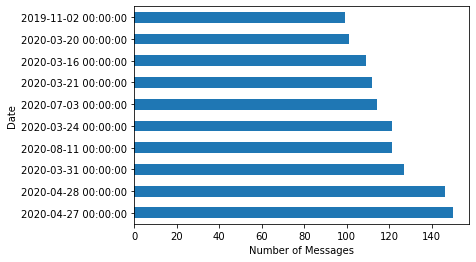

In [105]:
messages_df['Date'].value_counts().head(10).plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Date')

In [106]:

def dayofweek(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(dayofweek)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,1600]
    )),
  showlegend=False
)
fig.show()

In [107]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")
fig.show()

In [124]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="Word_Count", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
             title="Number of words per Author"
            )

fig.show()

In [117]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="MessageCount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
             title="Number of messages per Author"
            )
fig.show()

In [125]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="urlcount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "yellow","goldenrod", "magenta"],
             title="URL Count per Author"
            )

fig.show()

In [111]:
messages_df.iloc[messages_df['Word_Count'].argmax()]

Date                                              2020-01-02 00:00:00
Time                                                       5:10:57 PM
Author                                                             PK
Message             Dis, papa, c’est quoi, un Alsacien? Ce n'est p...
emoji                                                              []
urlcount                                                            0
Letter_Count                                                     2426
Word_Count                                                        427
MessageCount                                                        1
emojicount                                                          0
ratio_word_emoji                                                  inf
Name: 1468, dtype: object

Text(0, 0.5, 'Frequency')

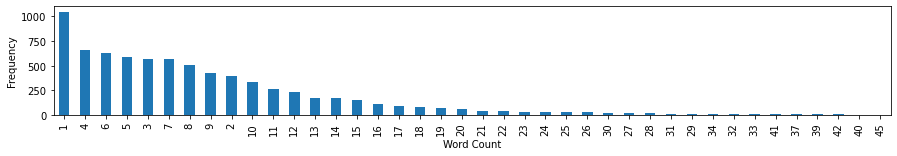

In [112]:
plt.figure(figsize=(15, 2)) # To ensure that the bar plot fits in the output cell of a Jupyter notebook
word_count_value_counts = messages_df['Word_Count'].value_counts()
top_40_word_count_value_counts = word_count_value_counts.head(40)
top_40_word_count_value_counts.plot.bar()
plt.xlabel('Word Count')
plt.ylabel('Frequency')

In [113]:
# Import packages
import numpy as np
from PIL import Image
# Import image to np.array
mask = np.array(Image.open('mask.png'))

In [114]:
text = " ".join(review for review in df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 344219 words in all the messages.


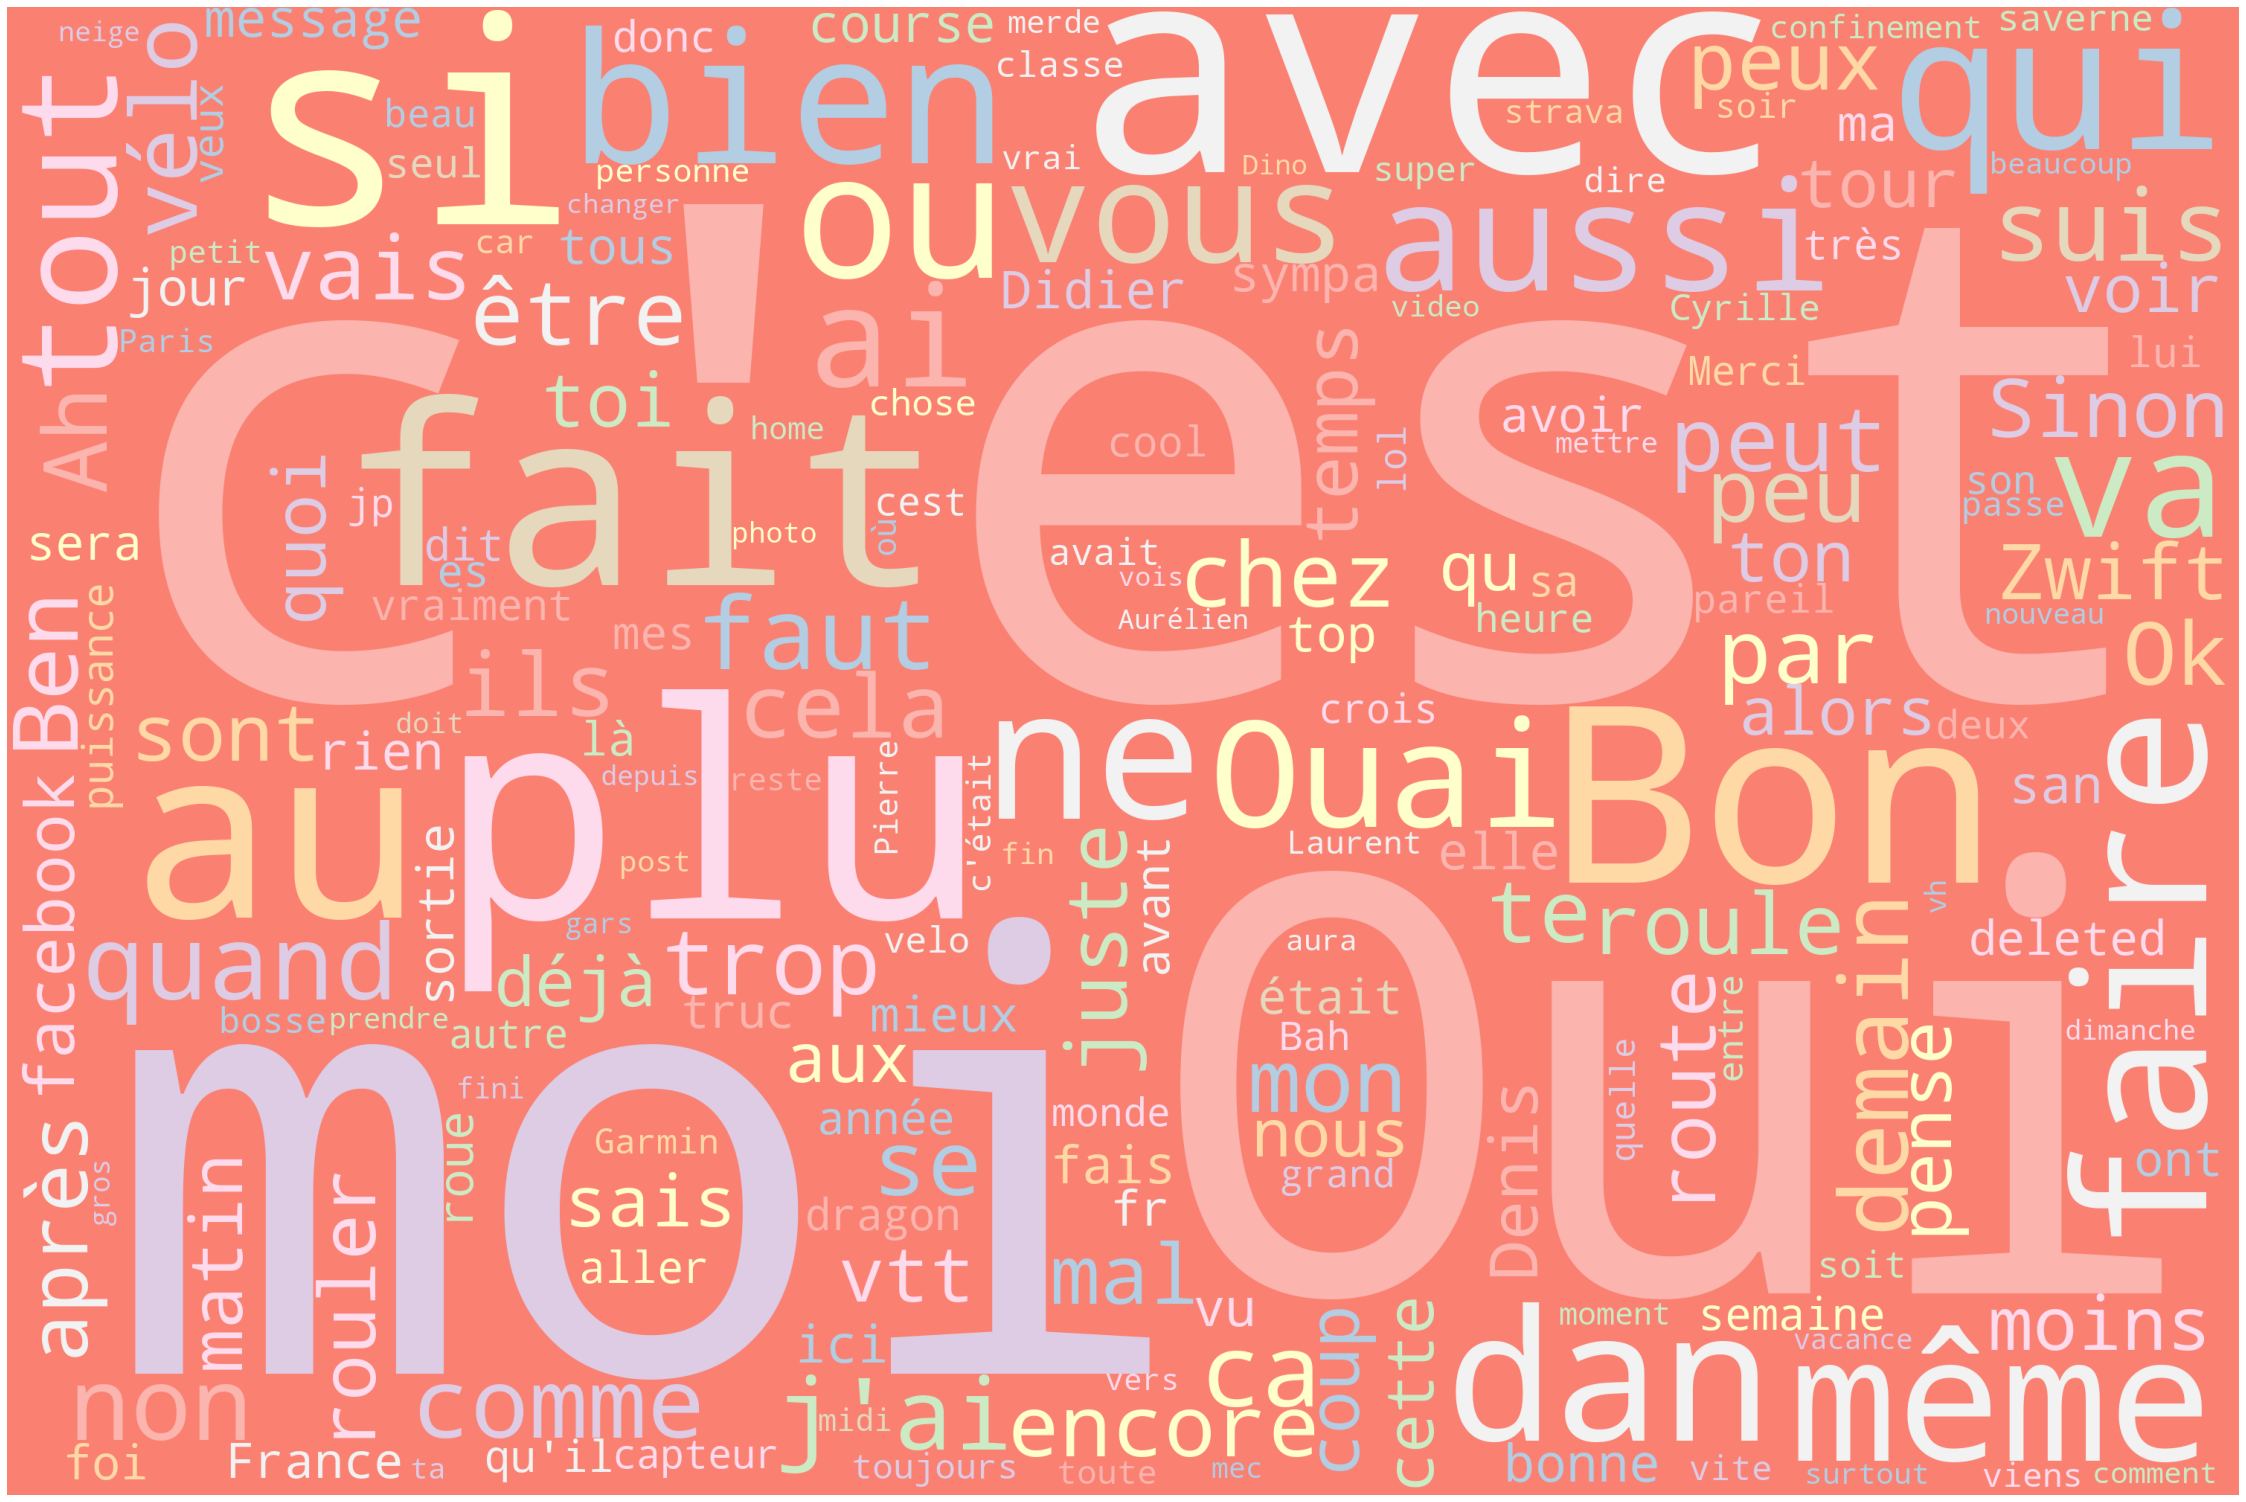

In [130]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    
STOPWORDS.update(['image','omitted','le', 'la','de','en','je','tu','et','pa','un','des','i','ça','les','il', 'pas','est','pour','que','c/est', 'sur', 'une', 'mai','du', 'mais','https','ce'])

# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(text)
# Plot
plot_cloud(wordcloud)

occurence of bike vs beer

number of words per emoji

In [ ]:
diversity of emoji